In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
from skimage import color
from skimage.exposure import rescale_intensity

# extending Pandas view limits
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Looking at AWS Rekognition Using Image of Pill

In [0]:
pillpic = imageio.imread('backlv.png')
pillpic_grayscale = rescale_intensity(1 - color.rgb2gray(pillpic))
pillpic_grayscale

In [0]:
pillpic_grayscale.shape

(351, 600)

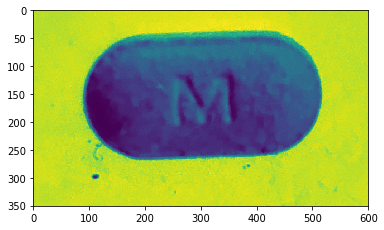

In [0]:
plt.imshow(pillpic_grayscale);

In [0]:
labelpic = imageio.imread('20190423_092450.jpg')
labelpic_grayscale = rescale_intensity(color.rgb2gray(labelpic+1))
labelpic_grayscale

array([[0.44031137, 0.44031137, 0.44031137, ..., 0.79007333, 0.79007333,
        0.79007333],
       [0.44031137, 0.44031137, 0.44031137, ..., 0.79007333, 0.79007333,
        0.79007333],
       [0.44031137, 0.44031137, 0.44031137, ..., 0.79007333, 0.79007333,
        0.79007333],
       ...,
       [0.39706039, 0.40098196, 0.40490353, ..., 0.15006118, 0.15006118,
        0.14613961],
       [0.38921725, 0.39313882, 0.39706039, ..., 0.15512157, 0.1512    ,
        0.14727843],
       [0.37745255, 0.38137412, 0.38921725, ..., 0.15512157, 0.15512157,
        0.1512    ]])

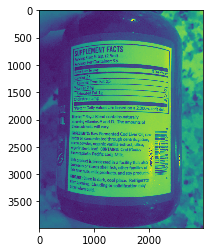

In [0]:
plt.imshow(labelpic_grayscale)

## Wrangling Pill Box Database from U.S. National Library of Medicine

Loading Data

In [0]:
df = pd.read_csv('https://pillbox.nlm.nih.gov/downloads/pillbox_201805.tab', sep='\t')

In [22]:
df.head()

,id,spl_id,SETID,spp,NDC9,PRODUCT_CODE,EQUAL_PRODUCT_CODE,author,SPLIMPRINT,SPLCOLOR,SPLSHAPE,SPLSIZE,SPLSCORE,DEA_SCHEDULE_CODE,INGREDIENTS,SPL_INACTIVE_ING,RXCUI,RXTTY,RXSTRING,image_id,IMAGE_SOURCE,HAS_IMAGE,FROM_SIS,NO_RXCUI
0,35339,NaN,a6b39b0c-3fb5-461c-aeae-3653cea7b121,a6b39b0c-3fb5-461c-aeae-3653cea7b121-76237-185-0,762370185,76237-185,0406-0360,McKesson Contract Packaging,M360,C48325,C48345,19.0,2,C48676,HYDROCODONE BITARTRATE[HYDROCODONE]; ACETAMINO...,"CROSPOVIDONE / MAGNESIUM STEARATE / CELLULOSE,...",NaN,NaN,NaN,NaN,NaN,0,1.0,NaN
1,27070,NaN,54b7e667-bb24-49a6-940d-226b2990d91b,54b7e667-bb24-49a6-940d-226b2990d91b-0363-0773-0,003630773,0363-0773,NaN,Walgreens Co,CPC64;A5,C48326,C48348,7.0,1,NaN,PHENAZOPYRIDINE HYDROCHLORIDE[PHENAZOPYRIDINE],"MAGNESIUM STEARATE / CELLULOSE, MICROCRYSTALLI...",1094126.0,SCD,Phenazopyridine hydrochloride 95 MG Oral Tablet,NaN,NaN,0,NaN,NaN
2,45909,NaN,6c9ef53b-b65f-4ba6-b1b0-43e12e0d9b3d,6c9ef53b-b65f-4ba6-b1b0-43e12e0d9b3d-24236-995-0,242360995,24236-995,53746-190,REMEDYREPACK INC.,IP190;500,C48325,C48335,16.0,1,NaN,NAPROXEN[NAPROXEN],CROSCARMELLOSE SODIUM / MAGNESIUM STEARATE / P...,198014.0,NaN,Naproxen 500 MG Oral Tablet,NaN,NaN,0,1.0,NaN
3,48191,NaN,8b1ca232-f84f-4d8f-9751-b103aa9337fb,8b1ca232-f84f-4d8f-9751-b103aa9337fb-30142-886-2,301420886,30142-886,NaN,Kroger Company,L272,C48329,C48345,16.0,1,NaN,ACETAMINOPHEN[ACETAMINOPHEN]; PHENYLEPHRINE HY...,ACESULFAME POTASSIUM / CARNAUBA WAX / CROSPOVI...,1046799.0,GPCK,{12 (Acetaminophen 325 MG / Chlorpheniramine M...,NaN,NaN,0,NaN,NaN
4,28462,NaN,8c4c786c-2b0f-4a23-a87d-effbcfe0c857,8c4c786c-2b0f-4a23-a87d-effbcfe0c857-42507-054-0,425070054,42507-054,NaN,HyVee Inc,L054,C48325,C48336,18.0,1,NaN,PSEUDOEPHEDRINE HYDROCHLORIDE[PSEUDOEPHEDRINE],CARNAUBA WAX / SILICON DIOXIDE / CALCIUM PHOSP...,1049154.0,SCD,12 HR Pseudoephedrine Hydrochloride 120 MG Ext...,NaN,NaN,0,NaN,NaN


### Number of Observations & Features in Raw DF

In [6]:
df.shape

(62898, 24)

### **Features with Nulls**


*   **`spl_id`:** All nulls
*   **`EQUAL_PRODUCT_CODE`:** missing in about half of the observations - this may be an alternate code for the pill
*   **`author`:** Pharmaceutical co. name
*   **`SPLIMPRINT:`** IMPORTANT --> This looks like the code imprinted on pill
*   **`SPLCOLOR`:** Pill color
*   **`SPLSHAPE`:** Pill shape 
*   **`SPLSIZE`:**  Pill size
*   **`SPLSCORE`:** Unknown score (ranging from 0 to 4)
*   **`DEA_SCHEDULE_CODE`:** Most are nulls - Seems to be another alternate code
*   **`INGREDIENTS`:**  Active ingredients 
*   **`SPL_INACTIVE_ING`:** Missing some more - Inactive ingredients
*   **`RXCUI`:**  Unknown values (large numbers - may be monetary)
*   **`RXTTY`:** Unkonwn values
*   **`RXSTRING`:** More details about pill
*   **`image_id`:** ID may match ID in another file
*   **`IMAGE_SOURCE`:** Source of 
*   **`HAS_IMAGE`:** Binary (image, no image)
*   **`FROM_SIS`:** Unknown binary values
*   **`NO_RXCUI`:** All nulls




After looking at all the features I would suggest to just keep the following columns: 

*   `NDC9`
*   `SPLIMPRINT`
*   `SPLCOLOR`
*   `SPLSHAPE`
*   `SPLSIZE`
*   `INGREDIENTS`
*   `SPL_INACTIVE_ING`  
*   `image_id`
*   `HAS_IMAGE`




In [8]:
df.isnull().sum()

id                        0
spl_id                62898
SETID                     0
spp                       0
NDC9                      0
PRODUCT_CODE              0
EQUAL_PRODUCT_CODE    32795
author                   12
SPLIMPRINT             1745
SPLCOLOR                  0
SPLSHAPE                  1
SPLSIZE                   0
SPLSCORE                  0
DEA_SCHEDULE_CODE     57430
INGREDIENTS             147
SPL_INACTIVE_ING       3076
RXCUI                  6423
RXTTY                 14348
RXSTRING               6379
image_id              54231
IMAGE_SOURCE          54231
HAS_IMAGE                 0
FROM_SIS              32795
NO_RXCUI              62898
dtype: int64

### Statistical Overview of DF

In [16]:
df.describe(include='all')

,id,spl_id,SETID,spp,NDC9,PRODUCT_CODE,EQUAL_PRODUCT_CODE,author,SPLIMPRINT,SPLCOLOR,SPLSHAPE,SPLSIZE,SPLSCORE,DEA_SCHEDULE_CODE,INGREDIENTS,SPL_INACTIVE_ING,RXCUI,RXTTY,RXSTRING,image_id,IMAGE_SOURCE,HAS_IMAGE,FROM_SIS,NO_RXCUI
count,62898.000000,0.0,62898,62898,62898,62898,30103,62886,61153,62898,62897,62898.000000,62898.000000,5468,62751,59822,5.647500e+04,48550,56519,8667,8667,62898.000000,30103.0,0.0
unique,NaN,NaN,42969,62898,60380,60381,8528,2500,16474,225,17,NaN,NaN,4,5058,24255,NaN,4,6956,8103,8,NaN,NaN,NaN
top,NaN,NaN,d7e3572d-56fe-4727-2bb4-013ccca22678,58b2bd93-e980-ed15-e053-2991aa0aca03-54973-3325-0,242360584,24236-584,65162-627,REMEDYREPACK INC.,I2,C48325,C48348,NaN,NaN,C48677,IBUPROFEN[IBUPROFEN],LACTOSE,NaN,SCD,Ibuprofen 200 MG Oral Tablet,no_product_image,VA3,NaN,NaN,NaN
freq,NaN,NaN,22,1,9,9,55,2408,153,26019,29065,NaN,NaN,2385,961,352,NaN,40579,443,188,1793,NaN,NaN,NaN
mean,31449.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.243925,1.261868,NaN,NaN,NaN,6.288362e+05,NaN,NaN,NaN,NaN,0.137795,1.0,NaN
std,18157.232953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.695272,0.501802,NaN,NaN,NaN,4.200799e+05,NaN,NaN,NaN,NaN,0.344687,0.0,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,9.179200e+04,NaN,NaN,NaN,NaN,0.000000,1.0,NaN
25%,15725.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,1.000000,NaN,NaN,NaN,2.850280e+05,NaN,NaN,NaN,NaN,0.000000,1.0,NaN
50%,31449.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,1.000000,NaN,NaN,NaN,4.775600e+05,NaN,NaN,NaN,NaN,0.000000,1.0,NaN
75%,47173.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,2.000000,NaN,NaN,NaN,9.038570e+05,NaN,NaN,NaN,NaN,0.000000,1.0,NaN


In [12]:
df.PRODUCT_CODE.nunique()

60381

In [21]:
# Only images for 8,667 pills
df.HAS_IMAGE.value_counts()

0    54231
1     8667
Name: HAS_IMAGE, dtype: int64

### Many pills are the same but produced by different pharmaceutical companies  (Have same `SPLIMPRINT` yet different `Authors` or `PRODUCT_CODE`)

There are actually 16,474 unique pills in the database 

In [30]:
# Number of pills with unique imprinted codes! ONLY 16k OUT OF 62k
df.SPLIMPRINT.nunique()

16474

In [43]:
# Pills with same SPLIMPRINT also match in SPLCOLOR, SPLSHAPE, SPLSIZE
# In essence, they're the same!
df1 = df.copy()
df1 = df1[df1.SPLIMPRINT.notnull()]
df1[df1['SPLIMPRINT'].str.contains("3229")]

,id,spl_id,SETID,spp,NDC9,PRODUCT_CODE,EQUAL_PRODUCT_CODE,author,SPLIMPRINT,SPLCOLOR,SPLSHAPE,SPLSIZE,SPLSCORE,DEA_SCHEDULE_CODE,INGREDIENTS,SPL_INACTIVE_ING,RXCUI,RXTTY,RXSTRING,image_id,IMAGE_SOURCE,HAS_IMAGE,FROM_SIS,NO_RXCUI
4566,57985,NaN,48980c85-2fa0-4c9e-b182-227b0d057f6b,48980c85-2fa0-4c9e-b182-227b0d057f6b-66993-043-0,669930043,66993-043,NaN,Prasco Laboratories,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",349594.0,SCD,atomoxetine 40 MG Oral Capsule,NaN,NaN,0,NaN,NaN
7187,9867,NaN,309de576-c318-404a-bc15-660c2b1876fb,309de576-c318-404a-bc15-660c2b1876fb-0002-5801-3,000025801,0002-5801,NaN,Eli Lilly and Company,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",895021.0,BPCK,{5 (atomoxetine 18 MG Oral Capsule [Strattera]...,NaN,NaN,0,NaN,NaN
7604,8631,NaN,309de576-c318-404a-bc15-660c2b1876fb,309de576-c318-404a-bc15-660c2b1876fb-0002-5800-4,000025800,0002-5800,NaN,Eli Lilly and Company,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",895019.0,BPCK,{5 (atomoxetine 10 MG Oral Capsule [Strattera]...,NaN,NaN,0,NaN,NaN
18228,17799,NaN,309de576-c318-404a-bc15-660c2b1876fb,309de576-c318-404a-bc15-660c2b1876fb-0002-5802-2,000025802,0002-5802,NaN,Eli Lilly and Company,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",895024.0,BPCK,{5 (atomoxetine 25 MG Oral Capsule [Strattera]...,NaN,NaN,0,NaN,NaN
19990,33684,NaN,96c69fdd-4a8d-4a8d-bcef-c8d2201a7980,96c69fdd-4a8d-4a8d-bcef-c8d2201a7980-68151-4487-0,681514487,68151-4487,0002-3229,Carilion Materials Management,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, CORN / DIMETHICONE / GELATIN / SODIUM ...",352320.0,SBD,atomoxetine 40 MG Oral Capsule [Strattera],NaN,NaN,0,1.0,NaN
20701,31941,NaN,a671ec20-1d70-45e1-9893-025f832444c5,a671ec20-1d70-45e1-9893-025f832444c5-54868-4741-0,548684741,54868-4741,0002-3229,"Physicians Total Care, Inc.",LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",352320.0,NaN,atomoxetine 40 MG Oral Capsule [Strattera],NaN,NaN,0,1.0,NaN
29162,24525,NaN,55df8d75-8c8e-485b-87a5-b920d7e10874,55df8d75-8c8e-485b-87a5-b920d7e10874-69189-3229-0,691893229,69189-3229,0002-3229,Avera McKennan Hospital,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",352320.0,SBD,atomoxetine 40 MG Oral Capsule [Strattera],NaN,NaN,0,1.0,NaN
47427,12858,NaN,309de576-c318-404a-bc15-660c2b1876fb,309de576-c318-404a-bc15-660c2b1876fb-0002-3229-0,000023229,0002-3229,NaN,Eli Lilly and Company,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",352320.0,SBD,atomoxetine 40 MG Oral Capsule [Strattera],00002-3229-30_3E1E1F50,NLM,1,NaN,NaN
48080,35561,NaN,23c702e2-3abc-4d7d-b88f-a089e2179f42,23c702e2-3abc-4d7d-b88f-a089e2179f42-55154-1825-0,551541825,55154-1825,0002-3229,Cardinal Health,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[Atomoxetine],"STARCH, Corn / DIMETHICONE / Gelatin / sodium ...",NaN,NaN,NaN,NaN,NaN,0,1.0,NaN
55874,37510,NaN,91c07d45-b77e-4349-a469-0d144fc23705,91c07d45-b77e-4349-a469-0d144fc23705-24236-882-0,242360882,24236-882,0002-3229,REMEDYREPACK INC.,LILLY;3229;40;mg,C48333,C48336,16.0,1,NaN,Atomoxetine hydrochloride[ATOMOXETINE],FD&C BLUE NO. 2 / FERROSOFERRIC OXIDE / STARCH...,352320.0,NaN,atomoxetine 40 MG Oral Capsule [Strattera],NaN,NaN,0,1.0,NaN


In [42]:
# When characters are separated by a space in the pills
# semicolons (`;`) take the places of spaces
df1[df1['SPLIMPRINT'].str.contains("M;L;15") | df1['SPLIMPRINT'].str.contains("L;15;M") ]

,id,spl_id,SETID,spp,NDC9,PRODUCT_CODE,EQUAL_PRODUCT_CODE,author,SPLIMPRINT,SPLCOLOR,SPLSHAPE,SPLSIZE,SPLSCORE,DEA_SCHEDULE_CODE,INGREDIENTS,SPL_INACTIVE_ING,RXCUI,RXTTY,RXSTRING,image_id,IMAGE_SOURCE,HAS_IMAGE,FROM_SIS,NO_RXCUI
39102,31526,NaN,e95720f2-91c9-a6d0-f7d5-8bcb94d07bbc,e95720f2-91c9-a6d0-f7d5-8bcb94d07bbc-0378-1823-0,003781823,0378-1823,NaN,Mylan Pharmaceuticals Inc.,M;L;15,C48334;C48333,C48345,9.0,2,NaN,LEVOTHYROXINE SODIUM[LEVOTHYROXINE],BUTYLATED HYDROXYANISOLE / SILICON DIOXIDE / C...,966270.0,SCD,Levothyroxine Sodium 0.137 MG Oral Tablet,00378-1823-01_D723EBAF,NLM,1,NaN,NaN
57944,41748,NaN,71139e30-10c8-4474-b7a3-b575c3fd32f9,71139e30-10c8-4474-b7a3-b575c3fd32f9-54868-5477-0,548685477,54868-5477,0378-1823,"Physicians Total Care, Inc.",M;L;15,C48334,C48336,9.0,2,NaN,LEVOTHYROXINE SODIUM[LEVOTHYROXINE],BUTYLATED HYDROXYANISOLE / SILICON DIOXIDE / C...,966270.0,SCD,Levothyroxine Sodium 0.137 MG Oral Tablet,NaN,NaN,0,1.0,NaN


In [28]:
df.SPLIMPRINT[0]

'M360'

### DataFrame with observations that have `SPLIMPRINT` & `image_id`

In [38]:
df_img = df1[(df1.SPLIMPRINT.notnull()) & (df1.image_id.notnull())]
df_img.head()

,id,spl_id,SETID,spp,NDC9,PRODUCT_CODE,EQUAL_PRODUCT_CODE,author,SPLIMPRINT,SPLCOLOR,SPLSHAPE,SPLSIZE,SPLSCORE,DEA_SCHEDULE_CODE,INGREDIENTS,SPL_INACTIVE_ING,RXCUI,RXTTY,RXSTRING,image_id,IMAGE_SOURCE,HAS_IMAGE,FROM_SIS,NO_RXCUI
47,49177,NaN,3f16166d-678e-51aa-e054-00144ff88e88,3f16166d-678e-51aa-e054-00144ff88e88-43063-721-0,430630721,43063-721,76385-102,"PD-Rx Pharmaceuticals, Inc.",BY4,C48327,C48348,8.0,1,NaN,PRIMAQUINE PHOSPHATE[PRIMAQUINE],"CELLULOSE, MICROCRYSTALLINE / STARCH, CORN / L...",904170.0,SCD,Primaquine Phosphate 26.3 MG Oral Tablet,no_product_image,NLM,1,1.0,NaN
50,4710,NaN,8fed703a-9de2-4c76-a783-fcf004f9b890,8fed703a-9de2-4c76-a783-fcf004f9b890-50844-175-0,508440175,50844-175,NaN,"L.N.K. International, Inc.",44;175,C48325,C48345,17.0,1,NaN,ACETAMINOPHEN[ACETAMINOPHEN],HYPROMELLOSES / POVIDONE / STEARIC ACID / CAST...,198440.0,SCD,Acetaminophen 500 MG Oral Tablet,50844-0175-10_NLMIMAGE10_5135A8AD,NLMIMAGE10,1,NaN,NaN
58,61985,NaN,c35d5dcc-8ee1-49da-993d-65c0195db918,c35d5dcc-8ee1-49da-993d-65c0195db918-70518-0901-0,705180901,70518-0901,0093-7206,REMEDYREPACK INC.,9;3;7206,C48330,C48348,7.0,2,NaN,MIRTAZAPINE[MIRTAZAPINE],"SILICON DIOXIDE / STARCH, CORN / HYPROMELLOSE ...",311725.0,SCD,Mirtazapine 15 MG Oral Tablet,00093720656,SPL,1,1.0,NaN
68,11648,NaN,2fb7763f-6ce4-43b9-b3be-90a66315828b,2fb7763f-6ce4-43b9-b3be-90a66315828b-60429-566-0,604290566,60429-566,0591-0744,"Golden State Medical Supply, Inc.",WATSON;744;1,C48325,C48338,9.0,2,C48677,ESTAZOLAM[ESTAZOLAM],DOCUSATE SODIUM / LACTOSE MONOHYDRATE / MAGNES...,NaN,NaN,NaN,604290566,VA2,1,1.0,NaN
71,47756,NaN,662f11ca-cf1e-41fd-9b2a-11a23d1f6290,662f11ca-cf1e-41fd-9b2a-11a23d1f6290-0781-1034-0,007811034,0781-1034,NaN,Sandoz Inc,GG55;5,C48327,C48348,8.0,1,NaN,TRIFLUOPERAZINE HYDROCHLORIDE[TRIFLUOPERAZINE],D&C RED NO. 30 / FD&C BLUE NO. 2 / HYDROXYPROP...,198325.0,SCD,Trifluoperazine 5 MG Oral Tablet,007811034,VA2,1,NaN,NaN


In [44]:
# 8,444 observations with SPLIMPRINT & having image
df_img.shape

(8444, 24)